In [ ]:
####################################################################################################
# Audio-driven upper-body motion synthesis on a humanoid robot
# Computer Science Tripos Part III Project
# Jan Ondras (jo356@cam.ac.uk), Trinity College, University of Cambridge
# 2017/18
####################################################################################################
# Further results (tables, plots) from validation of the MLP models (feature set choice).
####################################################################################################

MLP_SI EVALUATION ON VALIDATION SET:
MEANS
╒═══════════════╤═══════════╤═════════╤══════════════╤════════════════╤══════════════╕
│ Feature set   │   Loss    │  RMSE   │  Delta LCCA  │  LCCA (Yt,Yp)  │  Delta jerk  │
╞═══════════════╪═══════════╪═════════╪══════════════╪════════════════╪══════════════╡
│ MFCC 13       │ 0.0148071 │ 13.6644 │  0.0270486   │    0.976628    │    133086    │
├───────────────┼───────────┼─────────┼──────────────┼────────────────┼──────────────┤
│ LogFB 26      │ 0.0145858 │ 13.5176 │  0.0204153   │    0.976511    │    133166    │
├───────────────┼───────────┼─────────┼──────────────┼────────────────┼──────────────┤
│ LogFB 52      │ 0.0143924 │ 13.4373 │  0.0170003   │    0.975635    │    132863    │
├───────────────┼───────────┼─────────┼──────────────┼────────────────┼──────────────┤
│ LogFB 78      │ 0.0154247 │ 13.7342 │  0.00456732  │    0.97505     │    132707    │
╘═══════════════╧═══════════╧═════════╧══════════════╧════════════════╧══════════════╛


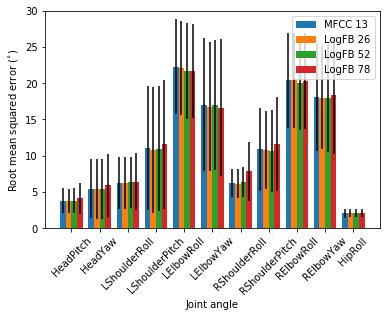

--------------------------------------------------
Loss :	1_35_AF13  x  1_35_AF26
	0.0875811857971586 0.9306949888369
	 samples A and B are NOT significantly different
--------------------------------------------------
Loss :	1_35_AF13  x  1_35_AF52
	0.1652082359354528 0.8697043297979798
	 samples A and B are NOT significantly different
--------------------------------------------------
Loss :	1_35_AF13  x  1_35_AF78
	-0.22625001731244382 0.8223163143119169
	 samples A and B are NOT significantly different
--------------------------------------------------
Loss :	1_35_AF26  x  1_35_AF52
	0.07658086003199653 0.9393810921843688
	 samples A and B are NOT significantly different
--------------------------------------------------
Loss :	1_35_AF26  x  1_35_AF78
	-0.3058364287683451 0.7615257796678543
	 samples A and B are NOT significantly different
--------------------------------------------------
Loss :	1_35_AF52  x  1_35_AF78
	-0.37851141558589513 0.7073265536803997
	 samples A and B are

In [4]:
import numpy as np
import time
import glob
import matplotlib.pyplot as plt
from tabulate import tabulate
from evalutils import plot_4RMSE, calculate_norm_delta_jerk_onList

tuning_types = [
    '1_35_AF13',
    '1_35_AF26', 
    '1_35_AF52', 
    '1_35_AF78'
]
feature_sets = [
    'MFCC 13',
    'LogFB 26', 
    'LogFB 52', 
    'LogFB 78'
]

TE_folder = 'TrainingExamples_16kHz'
unique_srt_VIDs = np.load('./../Dataset/'+TE_folder+'/te_unique_srt_VIDs.npz')['unique_srt_VIDs']
unique_srt_SIDs = np.array([x[:5] for i, x in enumerate(unique_srt_VIDs) if i % 2 == 0]) # ['PID02', 'PID05', ..

DATA = {} # stores all measures for all tuning types

for tt in tuning_types:
    DATA[tt] = np.zeros( ( len(unique_srt_SIDs), 5+11 ) ) # loss, RMSE, deltaLCCAxy, LCCAyy, deltaJerk

##########################################################################################
# MLP_SI
# VALIDATION - comparison of feature sets
##########################################################################################

for i, tuning_type in enumerate(tuning_types):
    save_results_path_prefix = './../Dataset/'+TE_folder+'/Results/MLP_SI/cvVal/'
    for s, SID in enumerate(unique_srt_SIDs):
        dd = np.load(save_results_path_prefix + 'val_' + tuning_type + '_' + SID + '.npz')
        DATA[tuning_type][s, 0] = dd['test_loss']
        DATA[tuning_type][s, 1] = dd['results_smooth'][1][0]
        DATA[tuning_type][s, 2] = abs(dd['results_smooth'][3]['XYt'][0] - dd['results_smooth'][3]['XYp'][0])  
        DATA[tuning_type][s, 3] = dd['results_smooth'][3]['YtYp'][0]
        #DATA[tuning_type][s, 4] = np.sum( dd['results_smooth'][4]['delta'] ) # sum over all angles
        # RECALCULATE JERK
        Y_true_list = dd['Y_true_list']
        Y_pred_list = dd['Y_smooth_list']
        DATA[tuning_type][s, 4] = np.sum( calculate_norm_delta_jerk_onList(Y_true_list, Y_pred_list) )
        DATA[tuning_type][s, 5:] = dd['results_smooth'][0][0]

##########################################################################################
headers = [
    'Feature set', 
    'Loss', 
    'RMSE', 
    'Delta LCCA',
    'LCCA (Yt,Yp)',
    'Delta jerk'
]
print "MLP_SI EVALUATION ON VALIDATION SET:"
# MEANS
print "MEANS"
tab_data = []
for m in tuning_types:
    tab_data.append( 
        np.mean( DATA[m][:, :5], axis=0 ) # average over subjects, keep 11 angles
    )
print tabulate(tab_data, headers=headers, 
               tablefmt='fancy_grid', 
               showindex=feature_sets, 
               numalign='center'
              )
print tabulate(tab_data, headers=headers, 
               tablefmt='latex_booktabs', 
               showindex=feature_sets, 
               numalign='center'
              )
# STDS
print "STDS"
tab_data = []
for m in tuning_types:
    tab_data.append( 
        np.std( DATA[m][:, :5], axis=0 ) # average over subjects, keep 11 angles
    )
print tabulate(tab_data, headers=headers, 
               tablefmt='fancy_grid', 
               showindex=feature_sets, 
               numalign='center'
              )

######################################################################################
RMSEbyAngles_means = []
RMSEbyAngles_stds = []

for m in tuning_types:
    RMSEbyAngles_means.append( 
        np.mean( DATA[m][:, 5:], axis=0 ) # average over subjects, keep 11 angles
    )
    RMSEbyAngles_stds.append( 
        np.std( DATA[m][:, 5:], axis=0 ) # average over subjects, keep 11 angles
    )

plot_4RMSE(RMSEbyAngles_means, feature_sets, RMSEbyAngles_stds, y_max=30)

#####################################################################################
####################################################################################
# Significance testing: for every measure, all pairs of models
from evalutils import statistical_significance

measures = ['Loss', 'RMSE', 'deltaLCCAxy', 'LCCAyy', 'deltaJerk']
for i in range(5):
    for i1, m1 in enumerate(tuning_types):
        for i2, m2 in enumerate(tuning_types):
            if i1 < i2:
                print "--------------------------------------------------\n", measures[i], ":\t", m1, " x ", m2
                statistical_significance( DATA[m1][:, i], DATA[m2][:, i], p_diff=0.001, verbose=False )


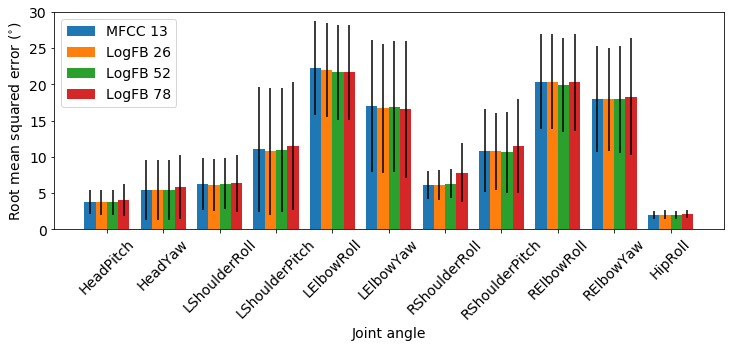

--------------------------------------------------
HeadPitch :	1_35_AF13  x  1_35_AF26
	0.0961371883366928 0.9239449184677825
	 samples A and B are NOT significantly different
--------------------------------------------------
HeadPitch :	1_35_AF13  x  1_35_AF52
	0.03079875162842798 0.9756001944923897
	 samples A and B are NOT significantly different
--------------------------------------------------
HeadPitch :	1_35_AF13  x  1_35_AF78
	-0.4696111719188705 0.6416334644974218
	 samples A and B are NOT significantly different
--------------------------------------------------
HeadPitch :	1_35_AF26  x  1_35_AF52
	-0.06482932490339897 0.9486685597311327
	 samples A and B are NOT significantly different
--------------------------------------------------
HeadPitch :	1_35_AF26  x  1_35_AF78
	-0.5507758299632916 0.585370081591405
	 samples A and B are NOT significantly different
--------------------------------------------------
HeadPitch :	1_35_AF52  x  1_35_AF78
	-0.49370616304774023 0.62467

	-0.1401524013101263 0.8893216782190051
	 samples A and B are NOT significantly different
--------------------------------------------------
RElbowYaw :	1_35_AF13  x  1_35_AF26
	0.00799030398464447 0.9936688861610439
	 samples A and B are NOT significantly different
--------------------------------------------------
RElbowYaw :	1_35_AF13  x  1_35_AF52
	0.03270036473863476 0.9740941976764997
	 samples A and B are NOT significantly different
--------------------------------------------------
RElbowYaw :	1_35_AF13  x  1_35_AF78
	-0.11833765747315406 0.9064639114849768
	 samples A and B are NOT significantly different
--------------------------------------------------
RElbowYaw :	1_35_AF26  x  1_35_AF52
	0.025264645882101353 0.9799836767477945
	 samples A and B are NOT significantly different
--------------------------------------------------
RElbowYaw :	1_35_AF26  x  1_35_AF78
	-0.12758306383359308 0.8992002068774705
	 samples A and B are NOT significantly different
----------------------

In [16]:
from evalutils import angles_names
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
def plot_4RMSE(rmses_byAngles, labels, stds=[], y_max=28.):
    
    N_series = len(labels)
    N_angles = len(rmses_byAngles[0])
    xaxis = np.arange(N_angles)
    w = 0.2 # bar width
    plt.figure(figsize=(12,4))
#     plt.figure()
    for i in range(N_series):
        if len(stds) == 0:
            plt.bar(xaxis - 0.5*N_series*w + i*w, rmses_byAngles[i], width=w, align='edge', label=labels[i])
        else:
            plt.bar(xaxis - 0.5*N_series*w + i*w, rmses_byAngles[i], yerr=stds[i], width=w, align='edge', label=labels[i])
    plt.ylabel('Root mean squared error ($^{\circ}$)') #, fontsize=14)
    plt.xlabel('Joint angle')
    plt.xticks(xaxis, angles_names[:N_angles], rotation=45)
    plt.ylim(0, y_max)
    plt.legend(loc='upper left')
    plt.show()
    

RMSEbyAngles_means = []
RMSEbyAngles_stds = []

for m in tuning_types:
    RMSEbyAngles_means.append( 
        np.mean( DATA[m][:, 5:], axis=0 ) # average over subjects, keep 11 angles
    )
    RMSEbyAngles_stds.append( 
        np.std( DATA[m][:, 5:], axis=0 ) # average over subjects, keep 11 angles
    )

plot_4RMSE(RMSEbyAngles_means, feature_sets, RMSEbyAngles_stds, y_max=30)

for i in range(len(angles_names[:11])):
    for i1, m1 in enumerate(tuning_types):
        for i2, m2 in enumerate(tuning_types):
            if i1 < i2:
                print "--------------------------------------------------\n", angles_names[i], ":\t", m1, " x ", m2
                statistical_significance( DATA[m1][:, 5+i], DATA[m2][:, 5+i], p_diff=0.001, verbose=False )

# %p<0.001:	nothing stat sig

In [5]:
#####################################################################################
####################################################################################
# Significance testing: for every measure, all pairs of models
from evalutils import statistical_significance

measures = ['Loss', 'RMSE', 'deltaLCCAxy', 'LCCAyy', 'deltaJerk']
for i in range(5):
    for i1, m1 in enumerate(tuning_types):
        for i2, m2 in enumerate(tuning_types):
            if i1 < i2:
                print "--------------------------------------------------\n", measures[i], ":\t", m1, " x ", m2
                statistical_significance( DATA[m1][:, i], DATA[m2][:, i], p_diff=0.05, verbose=False )

# %p<0.001:	13x52, 13x78, 26x78, 52x78 for DLCCA
# %p<0.05:		13x52, 13x78, 26x78, 52x78 for DLCCA; 13x78, 26x78 for LCCAY

--------------------------------------------------
Loss :	1_35_AF13  x  1_35_AF26
	0.0875811857971586 0.9306949888369
	 samples A and B are NOT significantly different
--------------------------------------------------
Loss :	1_35_AF13  x  1_35_AF52
	0.1652082359354528 0.8697043297979798
	 samples A and B are NOT significantly different
--------------------------------------------------
Loss :	1_35_AF13  x  1_35_AF78
	-0.22625001731244382 0.8223163143119169
	 samples A and B are NOT significantly different
--------------------------------------------------
Loss :	1_35_AF26  x  1_35_AF52
	0.07658086003199653 0.9393810921843688
	 samples A and B are NOT significantly different
--------------------------------------------------
Loss :	1_35_AF26  x  1_35_AF78
	-0.3058364287683451 0.7615257796678543
	 samples A and B are NOT significantly different
--------------------------------------------------
Loss :	1_35_AF52  x  1_35_AF78
	-0.37851141558589513 0.7073265536803997
	 samples A and B are